## **Installing and Importing Packages**

In [1]:
!pip install stop-words
!pip install nltk
!pip install scikit-multilearn
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 7.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 38.3 MB/s 
     |████████████████████████████████| 106 kB 71.2 MB/s 


In [2]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;
import nltk
import copy
import re
import contractions
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag;
from nltk.corpus import stopwords, wordnet;
from nltk.tokenize import WhitespaceTokenizer
nltk.download('omw-1.4')
#from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
 from google.colab import drive
 drive.mount('/content/drive/')

Mounted at /content/drive/


## **Initial data analysis**

In [4]:
train = pd.read_csv('/content/drive/MyDrive/ML_Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ML_Project/test.csv')
#train.head()
test.head()

,id,text
0,e0ae9d9474a5689a5791,in an interview before his execution
1,b64a191301cad4f11287,He knew what he was doing. The below posts are...
2,5e1953d9ae04bdc66408,Zzzzzzz... youre a real bore. Now go bore some...
3,23128f98196c8e8f7b90,"""\n\nYet, it remains confusion because the 910..."
4,2d3f1254f71472bf2b78,I was referring to them losing interest in van...


In [5]:
train[train.duplicated(['text'])] #To find duplicated data; Written by; Dewanshi Dewan

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate


In [6]:
train.describe() #Done together

,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
count,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000
mean,0.095782,0.010262,0.053067,0.002999,0.049150,0.008975
std,0.294294,0.100781,0.224168,0.054683,0.216182,0.094311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
train.isna().sum()  # To find the number of null values 

id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64

In [8]:
output = train.iloc[:, 2:8]   #Splitting the data into input and output data. 
input = train.iloc[:, 0:2]

testInput = test.iloc[:, 0:2]

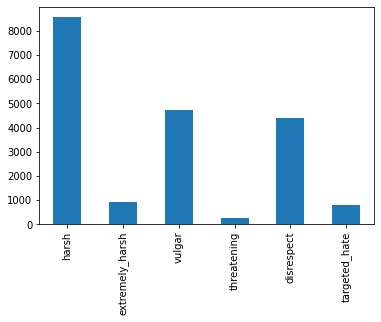

In [9]:
output.sum(axis=0).plot.bar()   #Plot for the distribution of data points for each category 

## **Test-train split**

In [10]:
#Performing the train-test split. For the sake of testing the model, we used 80-20 split.
X_train = input.iloc[:71451]
X_test = input.iloc[71451:]
Y_train = output.iloc[:71451]
Y_test = output.iloc[71451:]
# X_test = testInput[:] #For running it on the actual test dataset.

##**Preprocessing**

In [11]:
#Dry implementation of finding the POS tag first and then lemmatizing the word.

# text = "HI bitches I am laughing."
# tag = pos_tag(["detailed"])
# tag = tag[0][1]
# print(tag)
# tag_to_map = {"JJ": wordnet.ADJ,
#             "NN": wordnet.NOUN,
#             "VBG": wordnet.VERB,
#             "RB": wordnet.ADV}
# lemma = WordNetLemmatizer()
# lemma.lemmatize("detailed", tag_to_map.get(tag))

In [12]:
def summarizer(text): #Takes text as a comment and finds the summary of the text and returns the summary as tokens.
  def tokenize(text):
    return word_tokenize(text)   #To tokenize the words.
  def removeURL(text):
    return re.sub(r"http\S+", "", text)
  def toLower(text):            #To convert all words into lowercase
    return [text.lower() for text in text]
  def removePunc(text):          #To remove punctuation marks from the text.
    w = []
    for word in text:
      if(word.isalnum()):
        w.append(word)
    return w
  def modify(text):  #Remove words of length< 2
    w = []
    for word in text:
      if(len(word) > 2):
        w.append(word)
    return w
  def stopwordRem(text):         #To remove stopwords from the text.
    stopword = stopwords.words('english')
    text = list(filter(lambda word: word not in stopword, text))
    return text
  def remove_numbers(text):
      pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
      return re.sub(pattern, '', text)
  def lemmatize(text):          #To lemmatize the text using the parts of speech tag.
    def PartOfSpeechTag(text):
      tag = pos_tag([text])
      pos = tag[0][1]
      tag_to_map = {"JJ": wordnet.ADJ,
                  "NN": wordnet.NOUN,
                  "VBG": wordnet.VERB,
                  "RB": wordnet.ADV}
      return tag_to_map.get(pos, wordnet.NOUN)
    lemma = WordNetLemmatizer()
    lemmatized_text = ""
    for w in text:
      pos = PartOfSpeechTag(w)
      lemmatized_text += lemma.lemmatize(w, pos) + " "
    return lemmatized_text
    
  text = removeURL(text)
  text = remove_numbers(text)
  text = tokenize(text)
  # text = modify(text)
  text = toLower(text)
  text = removePunc(text)
  text = stopwordRem(text)
  text = lemmatize(text)
  return text

In [13]:
preprocessed_comments = []  #Calling the summarizer function and passing the text into the summarizer for training comments
for i in range(len(X_train)):
  if(i%1000 == 1):
    print(i)
  text = X_train._get_value(i, 'text', takeable=False)
  preprocessed_comments.append(summarizer(text))
preprocessed_comments

1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001
21001
22001
23001
24001
25001
26001
27001
28001
29001
30001
31001
32001
33001
34001
35001
36001
37001
38001
39001
40001
41001
42001
43001
44001
45001
46001
47001
48001
49001
50001
51001
52001
53001
54001
55001
56001
57001
58001
59001
60001
61001
62001
63001
64001
65001
66001
67001
68001
69001
70001
71001


['december utc interested argue policy resolve ongoing content dispute also see wikipedia wikiproject united state presidential election work also moneybomb closer selfreverted two different request echoed would requested rephrase see answer building agreement moneybomb redlink given deletion reversion outline article called moneybomb submitted afd due time latter see previous version however version require detailed answer ambiguity necessitate clarify question ',
 'added three miss parameter template infobox organization converted ca article information lost least one article company switched use infobox company template listed section wp typically mean redirect merge redirects help user find appropriate infobox see list redirect would like review conversion find edit history around middle page edits ',
 'sandbox madre sandbox ',
 'good sir sir obviously comprehend importance scope kind generous wikipedian take time understand effect article issue world hunger hear singapore lot dele

In [14]:
preprocessed_test_comments = [] ##alling the summarizer function and passing the text into the summarizer for test comments
for i in range(len(X_test)):
  if((i%1000) == 1):
    print(i)
  text = X_test._get_value(i+71451, 'text', takeable=False)
  preprocessed_test_comments.append(summarizer(text))
preprocessed_test_comments

1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001


['hoover murder investigation kennedy information hoover role murder investigation president kennedy well documented hoover personally directed investigation murder president john kennedy often called crime century first citation kennedy murder section article refers report congressional committee called house select committee assassination issued report three year investigation assassination john kennedy martin luther king robert kennedy report congressional committee critical performance fbi well agency second citation section kennedy murder pb frontline news show review official government record electrified top washington insider kept secret year secret document obtained assassination record review board many year sealed away public disclosure secret document fascinate especially reviewed pb hoover conferred nicholas katzenbach justice department approach investigation kennedy murder former attorney general grilled hsca year later intent convincing public neither left wing conspira

## **Training the model**

In [15]:
Vectorizer = TfidfVectorizer() #Takes words can returns a matrix represnting the text in terms of the occurences and frequencies of the vocabulary of the whole dataset.
X_train_TFrep = Vectorizer.fit_transform(preprocessed_comments)
X_test_TFrep = Vectorizer.transform(preprocessed_test_comments)
X_test_TFrep.shape

(17908, 100993)

## **Testing and evaluating the model**

In [27]:
#OVR is a multiclass classifier. It creates a classifier for each column like for eg: [harsh, rest] and LR is used for each classifier to find the predicted probabilities.
classifier = OneVsRestClassifier(LogisticRegression(solver = 'saga'))
categories = ["harsh", "extremely_harsh", "vulgar", "disrespect", "threatening", "targeted_hate"]
answer = pd.DataFrame()
classifier.fit(X_train_TFrep, Y_train)
probability = classifier.predict_proba(X_test_TFrep)
probability = np.round_(probability, decimals = 2)
prediction = classifier.predict(X_test_TFrep)
print('Test accuracy is {}'.format(roc_auc_score(Y_test, prediction)))
#After fitting and predicting the data, we dump the outputs into a .csv
# print(probability)
prediction.shape
df = pd.DataFrame()
df = X_test.iloc[:, 0:1]
df2 = pd.DataFrame(probability)
df = pd.concat([df, df2], axis=1, ignore_index=True)
# df.info()
df.to_csv("data1.csv")
# df.head()

Test accuracy is 0.6893262275451937


We have implemented the same OVR classifier but with multinomial NB to predict the probabilities

In [28]:
classifier2 = OneVsRestClassifier(MultinomialNB(fit_prior = True, class_prior = None))
categories = ["harsh", "extremely_harsh", "vulgar", "disrespect", "threatening", "targeted_hate"]

classifier2.fit(X_train_TFrep, Y_train)
# compute the testing accuracy
prediction = classifier2.predict(X_test_TFrep)
print('Test accuracy is {}'.format(roc_auc_score(Y_test, prediction)))
print(prediction)

Test accuracy is 0.5287017167637192
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


An ensemble of both the models implemented above.

In [29]:
ensemble = VotingClassifier(estimators =[('lr', classifier), ('NB_ovr', classifier2)],voting='soft')
categories = ["harsh", "extremely_harsh", "vulgar", "disrespect", "threatening", "targeted_hate"]
for category in categories:
  ensemble.fit(X_train_TFrep, Y_train[category])
  a = ensemble.predict_proba(X_test_TFrep)
  prediction = ensemble.predict(X_test_TFrep)
  print("for category: " + category + " " + str(roc_auc_score(Y_test[category], prediction)))
#create our voting classifier, inputting our models
# ensemble = VotingClassifier(estimators, voting=’hard’)

for category: harsh 0.6885307034203868
for category: extremely_harsh 0.5
for category: vulgar 0.6871354520715647
for category: disrespect 0.5958839231386318
for category: threatening 0.5
for category: targeted_hate 0.5029411764705882
